In [10]:
# Importing working libraries
import os
import cv2
import copy
import numpy as np
import tensorflow as tf
from google.colab import drive # Comment when working in Visual Studio Code
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow # colab do not support cv2.imshow()

# Import from my google drive
drive.mount('/content/drive') # Comment when working in Visual Studio Code

# Loaded the main project folder
project_path = "/content/drive/MyDrive/Colab Notebooks/Personal Project/Road Sign Detection"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [39]:
cat_files = glob('../input/cat-and-dog/training_set/training_set/cats/*.jpg')
dcat_files = glob('../input/cat-and-dog/training_set/training_set/dogs/*.jpg')

# current_notebook_dir = find_current_notebook_dir()

NameError: name 'find_current_notebook_dir' is not defined

In [11]:
# Définition du modèle
model = tf.keras.applications.MobileNetV2(weights='imagenet')

# Compilation du modèle
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [12]:
# # Affichage du résumé du modèle
# model.summary()

In [13]:
# # Chemin utile pour charger le modèle YOLO
# darknet_path = os.path.join(project_path,"pre-trained YOLO","darknet")
# labels_file = os.path.join(darknet_path,"data","coco.names")
# config_file = os.path.join(darknet_path,"cfg","yolov3.cfg")
# weights_file = os.path.join(darknet_path,"weights","yolov3.weights")

In [14]:
# # Liste des classes (noms des objets détectés)
# labels = []
# with open(labels_file, "r") as f:
#     labels = f.read().strip().split('\n')

# # Définir un dictionnaire pour mapper chaque classe à une couleur
# class_colors = {}
# for i, class_name in enumerate(labels):
#     hue = int(360 * i / len(labels))  # Répartition des couleurs sur le cercle chromatique 360
#     color = np.array([hue,255,255], dtype=np.uint16)
#     color = cv2.cvtColor(np.uint8([[color]]), cv2.COLOR_HSV2BGR)[0][0]
#     class_colors[class_name] = tuple(int(c) for c in color)

In [24]:
# # Charger les images
# images_name = ["road1.png"]
# images_file = [os.path.join(darknet_path,"data",image_name) for image_name in images_name]
# images = [cv2.imread(image_file) for image_file in images_file]

# Charger les images
image_name = "road1.png"
image_file = os.path.join(project_path,"dataset","images",image_name)
image = cv2.imread(image_file)

# Convertir de BGR à RGB
image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

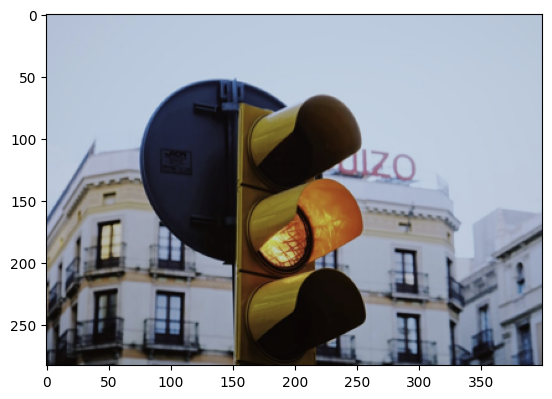

In [25]:
# Afficher l'image
plt.imshow(image)
plt.show()

In [33]:
# Prétraiter l'image
resized = cv2.resize(image, (224,224))
resized = tf.keras.preprocessing.image.img_to_array(resized)
resized = tf.keras.applications.mobilenet_v2.preprocess_input(resized)

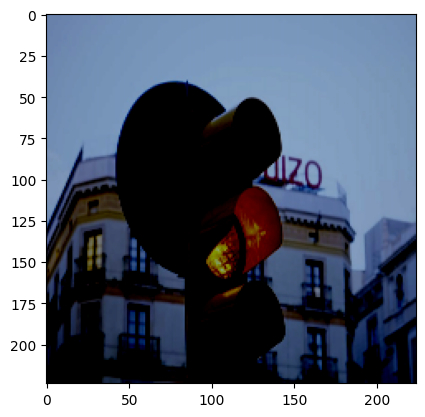

In [34]:
# Afficher l'image
plt.imshow(resized)
plt.show()

In [35]:
# Faire une prédiction
predictions = model.predict(np.array([resized]))
decoded_predictions = tf.keras.applications.mobilenet_v2.decode_predictions(predictions, top=5)

35363/35363 [==============================] - 0s 0us/step


In [38]:
# print(predictions)
print(decoded_predictions)

[[('n06874185', 'traffic_light', 0.99222773), ('n06794110', 'street_sign', 0.0005917795), ('n02807133', 'bathing_cap', 0.0003457275), ('n03047690', 'clog', 0.0002240408), ('n02782093', 'balloon', 0.00022224219)]]


In [ ]:
# Charger le modèle YOLO pré-entraîné
net = cv2.dnn.readNet(weights_file,config_file)
# Définir les noms des couches de sortie
output_layer_names = net.getUnconnectedOutLayersNames()

In [ ]:
def detection_of_all_boxes(image):
    # Redimensionner l'image et normaliser les valeurs des pixels
    blob = cv2.dnn.blobFromImage(image, 1/255.0, (416, 416), swapRB=True, crop=False)
    # Charger l'image dans le réseau
    net.setInput(blob)
    outputs = net.forward(output_layer_names)
    # Initialiser des listes pour les boîtes de détection, les confiances et les classes
    boxes = []
    confidences = []
    class_ids = []
    # Parcourir toutes les sorties du modèle
    for output in outputs:
        for detection in output:
            scores = detection[5:]  # Les scores de confiance pour chaque classe
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > 0.5:  # Seuil de confiance
                # Coordonnées de la boîte de détection
                center_x = int(detection[0] * image.shape[1])
                center_y = int(detection[1] * image.shape[0])
                width = int(detection[2] * image.shape[1])
                height = int(detection[3] * image.shape[0])
                # Coordonnées de l'angle supérieur gauche de la boîte
                x = int(center_x - width / 2)
                y = int(center_y - height / 2)
                # Ajout des éléments au listes
                boxes.append([x, y, width, height])
                confidences.append(float(confidence))
                class_ids.append(class_id)
    # Return
    return(boxes,confidences,class_ids)

def non_maximum_suppression(boxes,confidences):
    # Appliquer la suppression non maximale
    indices = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)
    return(indices)

def draw_bounding_boxes(image,boxes,confidences,class_ids,indices):
    # Copier l'image afin d'affecter des modifications à sa copie
    image_copied = copy.deepcopy(image)
    # Dessiner les boîtes de détection sur l'image d'origine
    for i in range(len(boxes)):
        if i in indices:
            x, y, w, h = boxes[i]
            label = labels[class_ids[i]]
            confidence = confidences[i]
            if label in class_colors:
                color = class_colors[label]
            else:
                color = (0, 0, 0)  # Couleur par défaut (noir)
            cv2.rectangle(image_copied, (x, y), (x + w, y + h), color, 2)
            cv2.putText(image_copied, f"{label} {confidence:.2f}", (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
    # Return
    return(image_copied)

In [ ]:
# Détection grâce au modèle
images_with_detection = []
for image in images:
  boxes,confidences,class_ids = detection_of_all_boxes(image)
  indices = non_maximum_suppression(boxes,confidences)
  image_with_detection = draw_bounding_boxes(image,boxes,confidences,class_ids,indices)
  images_with_detection.append(image_with_detection)

In [ ]:
# Afficher les détections

# Créez une figure avec deux colonnes de sous-plots
num_images = len(images)
fig, axes = plt.subplots(num_images, 2, figsize=(10, 5 * num_images))

# Parcourez les images et affichez-les dans les deux colonnes avec les titres appropriés
for i in range(num_images):
    ax1 = axes[i, 0]
    ax1.imshow(images[i])
    ax1.set_title("Avant détection")
    ax1.axis('off')

    ax2 = axes[i, 1]
    ax2.imshow(images_with_detection[i])
    ax2.set_title("Après détection")
    ax2.axis('off')

# Ajustez l'espacement entre les sous-plots
plt.tight_layout()

# Affichez la figure
plt.show()

Output hidden; open in https://colab.research.google.com to view.